# Lotka Volterra UPINN

In [1]:
import torch
import sys
import pysindy as ps
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../')

from utils.BVP import BVP
from utils.UPINN import UPINN
from utils.DataGenerators import LotkaVolterra, sample_with_noise
from utils.Architectures import FNN
from utils.Plotters import LV_Plotter

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [2]:
###############################################
### Generate data from Lotka-Volterra model ###
###############################################
###   dx/dt = alpha*x - beta*x*y            ###
###   dy/dt = gamma*x*y - delta*y           ###
###############################################
# alpha, beta, gamma, delta = 1.3, 0.9, 0.8, 1.8
# x0, y0 = 0.44249296, 4.6280594

alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
x0, y0 = 1.0, 1.0

LV = LotkaVolterra(alpha, beta, gamma, delta, torch.tensor([x0, y0], dtype=torch.float32))

# time_int = [0, 3]
time_int = [0, 10]
# train_test = 1.0
train_test = 0.8
N = 800
t = torch.linspace(time_int[0], time_int[1], N)
X = LV.solve(t)
train_idx = torch.arange(0, train_test*N, dtype=torch.long)
test_idx = torch.arange(train_test*N, N, dtype=torch.long)

# Sample subset and add noise
t_d, X_d = sample_with_noise(10, t[train_idx], X[train_idx], epsilon=0.0)

### Setup Boundary Value Problem

Assume that $-\beta x y$ and $\gamma x y$ is not known, and we want to learn them from data.

In [3]:
class LV_BVP(BVP):
    
    def __init__(self, params, X0):
        super().__init__(params)
        self.X0 = X0

    def f(self, z, U):
        alpha = self.params['alpha'] if 'alpha' in self.params else self.alpha
        beta = self.params['beta'] if 'beta' in self.params else self.beta
        delta = self.params['delta'] if 'delta' in self.params else self.delta
        gamma = self.params['gamma'] if 'gamma' in self.params else self.gamma

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - alpha*U[:, 0], # + beta*U[:, 0]*U[:, 1],
            dUdt[:, 1] + delta*U[:, 1] # - gamma*U[:, 0]*U[:, 1] # <-- Estimate this
        ], dim=-1)

    def g(self, z, U):
        return U - self.X0

# Define model
# params = dict(
#     alpha=torch.nn.Parameter(torch.tensor(0.5)),
#     beta=torch.nn.Parameter(torch.tensor(0.5)),
#     delta=torch.nn.Parameter(torch.tensor(0.5))
# )

params = dict(
    alpha=torch.nn.Parameter(torch.tensor(1.0)),
    beta=torch.nn.Parameter(torch.tensor(1.0)),
    delta=torch.nn.Parameter(torch.tensor(1.0)),
    # delta=delta,
    gamma=torch.nn.Parameter(torch.tensor(1.0))
)

params = dict(
    alpha=alpha,
    beta=beta,
    delta=delta,
    gamma=gamma
)

bvp = LV_BVP(params, torch.tensor([x0, y0], dtype=torch.float32))

### Setup UPINN

In [4]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.ReLU(),
)
G = FNN(
    dims=[2, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)


# u = FNN(
#     dims=[1, *[64, 64], 2],
#     hidden_act=torch.nn.Sigmoid(),
#     output_act=torch.nn.Identity(),
# )
# G = FNN(
#     dims=[2, *[16, 16], 2],
#     hidden_act=torch.nn.Sigmoid(),
#     output_act=torch.nn.Identity(),
# )

# Setup scaling layer
u.scale_fn = lambda t_: (t_-t.min())/(t.max()-t.min())
mu, sigma = 0, 2
epsilon = 1e-8
G.scale_fn = lambda x: (x-mu)/(sigma+epsilon)


upinn = UPINN(u, G, bvp=bvp)

Make a class that can plot the results of the UPINN.

In [5]:
plotter = LV_Plotter(t, X, t_d, X_d, -beta*X[:, 0]*X[:, 1] , gamma*X[:, 0]*X[:, 1])

In [6]:
plots = plotter(upinn.u, upinn.G)
plots["Solution"].show()
plots["Missing Terms"].show()

## Train UPINN

In [ ]:
upinn.train(
    data_points=t_d.unsqueeze(-1),
    data_target=X_d,
    boundary_points=torch.tensor([[0.0]]),
    collocation_points=t[train_idx].unsqueeze(-1).requires_grad_(True),
    epochs=10000,
    # log_wandb=dict(name='UPINN', project='Master-Thesis', plotter=plotter, plot_interval=1000),
    log_wandb=None,
    optimizer=torch.optim.AdamW,
    optimizer_args=dict(lr=3e-3, weight_decay=1e-10),
    beta_softadapt=0.1,
    # scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    # scheduler_args=dict(factor=0.9, patience=100, min_lr=1e-6),
    loss_tol=1e-6,
    lambda_reg=1e-3,
    # priotize_pde=100.0
    save_model=dict(path='../models/lotka-volterra', name='pde_find')
    )
upinn.to('cpu')

Beginning training...
Running on: cuda


100%|██████████| 10000/10000 [02:01<00:00, 82.34it/s, Loss=4e-6, BC Loss=0, PDE Loss=6e-6, Data Loss=6e-6, Reg Loss=0.579, LR_reg=0.001]                  

Training complete.
Saving model...


In [8]:
plots = plotter(upinn.u, upinn.G)
plots["Solution"].show()
plots["Missing Terms"].show()

## Find symbolic expression for unknown terms

In [11]:
# Generate data from the solution network
t = np.linspace(0, 8, 1000).reshape(-1, 1)
X = upinn.u(torch.tensor(t, dtype=torch.float32)).detach().numpy()
X_dot = upinn.G(torch.tensor(X, dtype=torch.float32)).detach().numpy()

# Split data into training and test set
train_test_split = 0.8
train_idx = np.arange(0, int(train_test_split*len(t)))
test_idx = np.arange(int(train_test_split*len(t)), len(t))

In [13]:
# Define your SINDy library
lib = ps.PolynomialLibrary(degree=2)

# Generate taus to test
taus = np.linspace(0.1, 1.0, 100)

# Define time series cross-validation
n_splits = 5  # Number of splits (adjust based on data size)
split_size = len(X) // (n_splits + 1)  # Ensure proper train-test splits

mean_scores = np.zeros_like(taus)

for i, tau in enumerate(taus):
    scores = []  # Store scores for each time split

    # Perform time series cross-validation
    for split in range(n_splits):
        train_end = split_size * (split + 1)
        test_start = train_end
        test_end = test_start + split_size

        # Define train and test indices
        train_idx = np.arange(0, train_end)
        test_idx = np.arange(test_start, min(test_end, len(X)))

        # Initialize the SINDy model with the current tau
        model = ps.SINDy(
            feature_library=lib,
            optimizer=ps.STLSQ(threshold=tau),
        )

        # Fit the model on the training set
        model.fit(x=X[train_idx], t=t[train_idx], x_dot=X_dot[train_idx])

        # Score the model on the testing set
        scores.append(model.score(X[test_idx], t=t[test_idx], x_dot=X_dot[test_idx]))

    # Compute the mean score across all splits for this tau
    mean_scores[i] = np.mean(scores)

# Find the best tau
best_tau = taus[np.argmax(mean_scores)]
print(f'Best tau: {best_tau}')

# Fit the model with the best tau on the entire dataset
final_model = ps.SINDy(
    feature_library=lib,
    optimizer=ps.STLSQ(threshold=best_tau),
    feature_names=['x', 'y']
)
final_model.fit(x=X, t=t, x_dot=X_dot)
final_model.print()

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning:

Sparsity parameter is too big (0.36363636363636365) and eliminated all coefficients

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning:

Sparsity parameter is too big (0.36363636363636365) and eliminated all coefficients

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning:

Sparsity parameter is too big (0.3727272727272727) and eliminated all coefficients

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning:

Sp

Best tau: 0.24545454545454545
(x)' = -1.336 x y
(y)' = 0.999 x y


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning:

Sparsity parameter is too big (1.0) and eliminated all coefficients



In [19]:
def 

['-1.333 x0 x1', '0.000']

In [13]:
# Prepare the data for PySINDy
input_data = np.column_stack((x_data, y_data))  # Combine x and y as inputs
output_data = np.column_stack((missing_dx_data, missing_dy_data))  # Combine missing terms

NameError: name 'x_data' is not defined

(x)' = -1.334 x y
(y)' = 0.989 x y


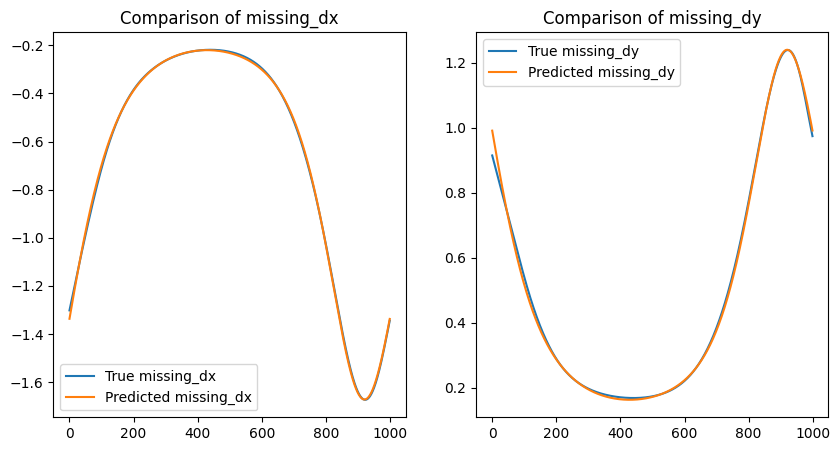

In [22]:
model = ps.SINDy(feature_library=lib, feature_names=["x", "y"], optimizer=ps.STLSQ(threshold=0.3))
model.fit(input_data, x_dot=output_data, t=t_eval.detach().numpy())
model.print()
# Predict using the discovered dynamics
predicted_missing = model.predict(input_data)

# Compare true vs. predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(missing_dx_data, label="True missing_dx")
plt.plot(predicted_missing[:, 0], label="Predicted missing_dx")
plt.legend()
plt.title("Comparison of missing_dx")

plt.subplot(1, 2, 2)
plt.plot(missing_dy_data, label="True missing_dy")
plt.plot(predicted_missing[:, 1], label="Predicted missing_dy")
plt.legend()
plt.title("Comparison of missing_dy")
plt.show()